# Exploring Fair Face with CLIP and GradCAM

## Imports

In [7]:
import clip
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image
import torch
import numpy as np
import torch.nn.functional as F
from pathlib import Path
from scipy.ndimage import gaussian_filter
from torch import nn

In [5]:
%matplotlib inline

print('\nLoading model...')
available_models = ['RN50', 'RN101', 'RN50x4', 'RN50x16']
layers = ['layer4', 'layer3', 'layer2', 'layer1']

clip_model = available_models[0]
saliency_layer = layers[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)
print(f"Done! Model loaded to {device} device")


Loading model...
Done! Model loaded to cuda device


## Helper functions

In [8]:
def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    return x / 0.6

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    img = img[:,:,:1]
    if blur:
        attn_map = gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('plasma')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, title, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.title(title)
    plt.show()

def save_attn(img, attn_map, title, fname, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.title(title)
    plt.savefig(fname, bbox_inches='tight')
    
def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

## GradCAM

In [9]:
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad

# Reference: https://arxiv.org/abs/1610.02391


def gradCAM(
        model: nn.Module,
        input: torch.Tensor,
        target: torch.Tensor,
        layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        # Do a forward and backward pass
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel dimension
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence
        # so we clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(gradcam,
                            input.shape[2:],
                            mode='bicubic',
                            align_corners=False)

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam

## FairFace DataFrame

In [43]:
path = "/home/lazye/Documents/ufrgs/mcs/datasets/FairFace/"
fface_df = pd.read_csv(f"{path}/train/fairface_label_train.csv")
print(fface_df.head())

          file    age  gender        race  service_test
0  train/1.jpg  50-59    Male  East Asian          True
1  train/2.jpg  30-39  Female      Indian         False
2  train/3.jpg    3-9  Female       Black         False
3  train/4.jpg  20-29  Female      Indian          True
4  train/5.jpg  20-29  Female      Indian          True


Preview some images

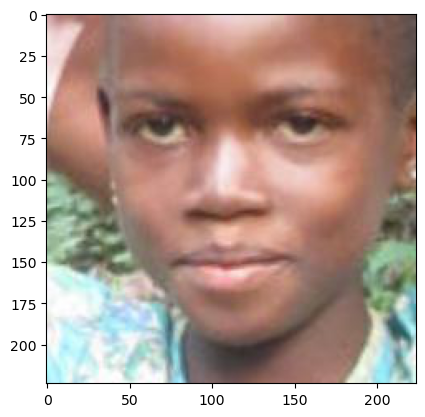

In [45]:
im_path = path + fface_df.iloc[2]['file']
with Image.open(im_path) as im:
        plt.imshow(im)
        plt.show()

## Image Grid

In [64]:
from mpl_toolkits.axes_grid1 import ImageGrid
im_set = list()
for file in fface_df.iloc[0:4]['file']:
    im_path = path + file
    im_set.append(plt.imread(im_path))

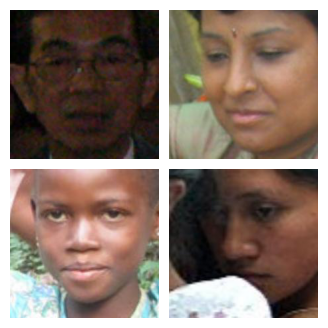

In [74]:
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,
                 )


for ax, im in zip(grid, im_set):
    ax.set_axis_off()
    ax.imshow(im)

plt.savefig('imgrid.png', bbox_inches='tight')